In [28]:
import coldatoms
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

# Introduction

Doppler cooling is one of the most important experimental techniques in cold atom science. Perhaps it's indicative of the impact of this technology that at least five of the names associated with the early days of laser cooling (Wineland, Hansch, Chu, Tannoudji, and Phillips) went on to earn Nobel Prizes in Physics, most of them directly for laser cooling and others for the lifetime contributions to cold atom science. William D. Phillips' Nobel lecture gives a good overview of some of the ways in which laser cooling has had an impact in low energy physics and other areas of physics research.

In this notebook we explore how Doppler cooling, the simplest form of laser cooling, can be modeled in the coldatoms library.

Central to laser cooling is the radiation pressure force generated by photons resonantly scattering off of atoms. For a two level atom the scattering rate is given by

$$
\dot{n} = S\frac{\gamma_0}{2\pi}\frac{\left(\gamma_0/2\right)^2}{\left((\gamma_0/2)^2(1+2S)+\Delta^2(\mathbf{v})\right)}
$$

In this equation, $S$ is the intensity of the laser in units of the saturation intesnity, $2\pi/\gamma_0$ is the excited state lifetime, and $\Delta$ is the detuning of the laser frequency from the atomic resonance frequency.

Each time the atom absorbs and reemits a photon it receives a recoil kick. Very absorbed photon comes out the the beam and therefore has a well defined momentum ($\hbar \mathbf{k}$ where $\mathbf{k}$ is the wavevector of the laser). The emitted photons travel in more or less random directions and the force due to them therefore averages approximately to zero. The net result is a forc eon the atom along the direction of propagagation of the laser beam and a fluctuating force that is more or less isotropic.

Now comes the imporatnt part that allows us to use this force for cooling: The detuning $\Delta$ of the laser from the atomic transition is velocity dependent due to the Doppler shift. In free space we have

$$
\Delta(\mathbf{v}) = \omega_L - \omega_A - \mathbf{k}\cdot\mathbf{v}
$$

If we then "red detune" the laser i.e. we choose a laser frequency such that $\omega_L<\omega_A$, it is easy to see that atoms moving towards the laser with $\mathbf{k}\cdot\mathbf{v}<0$, will scatter more photons than atoms moving away from the laser. They will hence experience a decelerating force if they're moving towards the laser beam.

"Wait a second" you say. "That's all good and fine. The atoms are slowed down if they're moving in the opposite direction as the laser's propagation direction. But what if they move _in_ the direction of propagation of the laser. Won't they get _accelerated_ in that case?"

You are correct! One laser beam can only slow down the atoms if they're going one way. To slow them down going either direction we need a second laser that is propagating in the opposite direction. By combining six such lasers, a pair for each Cartesian direction, we can achieve cooling of the atoms' motion in all three spatial directions.

We have neglected the fluctuating force due to the emitted photons so far. Unfortunately these recoil kicks never cancel completely because they are uncorrelated with one another. The recoil kicks make th atoms undergo a random walk in momentum space. They are a _heating_ mechanism.

The balance between the cooling rate due to the coeherent friction force from absorption and the heating due to the incoherent emission events corresponds to the lowest temperature that can be achieved by Doppler cooling. This temperature is called the Doppler temperature. We will determine it computationally later in this notebook.

It may be worth mentioning that many laser cooling schemes exist that are able to achieve temperatures lower than the Doppler limit. We will not consider these so called sub-Doppler schemes here.


# Doppler cooling in coldatoms

So how dow we simulate Doppler cooling using the coldatoms library? The answer is we use the RadiationPressure force. This force mimicks the momentum recoil due to absorption and emission of photons in resonance fluorescence. The RadiationPressure force is completely determined by the excited state decay rate $\gamma_0$, the driving laser's wavevector $\mathbf{k}$, the laser intensity, and the detuning of the laser from the atomic transition frequency. The intensity is a function of the atomic position because the laser intensity varies throughout space. The detuning depends on the atomic position and velocity. It depends on position because external fields may lead to shifts of the atomic transition frequency (e.g. magnetic fields leading to Zeeman shifts) and it depends on velocity via the Doppler shift.

In this notebook we consider a well collimated Gaussian laser beam. It has an intensity profile given by

$$
S(\mathbf{x})=S_0e^{-x_\perp^2/\sigma^2}
$$

where $S_0$ is the peak intensity of the beam, $\sigma$ is the width of the beam, and $x_\perp=\mathbf{x}-\mathbf{x_0} - (\mathbf{x}-\mathbf{x_0})\cdot \mathbf{k}/k$ is the distance of the atom from the center of the beam. We represent the intensity by the following Python class:

In [2]:
class GaussianBeam(object):
    """A laser beam with a Gaussian intensity profile."""
    
    def __init__(self, S0, x0, k, sigma):
        """Construct a Gaussian laser beam from position, direction, and width.
        
        S0 -- Peak intensity (in units of the saturation intensity).
        x0 -- A location on the center of the beam.
        k -- Propagation direction of the beam (need not be normalized).
        sigma -- 1/e width of the beam."""
        self.S0 = S0
        self.x0 = np.copy(x0)
        self.k_hat = k / np.linalg.norm(k)
        self.sigma = sigma
        
    def intensities(self, x):
        xp = x - self.x0
        xperp = xp - np.outer(xp.dot(self.k_hat[:, np.newaxis]), self.k_hat)
        return self.S0 * np.exp(-np.linalg.norm(xperp, axis=1)**2/self.sigma)

The following figure shows a contour plot of such a beam originating at $\mathbf{x}_0=(1,1,0)^T$ and propagating in the $\mathbf{k}=(1, 1, 0)^T$ direction.

<IPython.core.display.Javascript object>


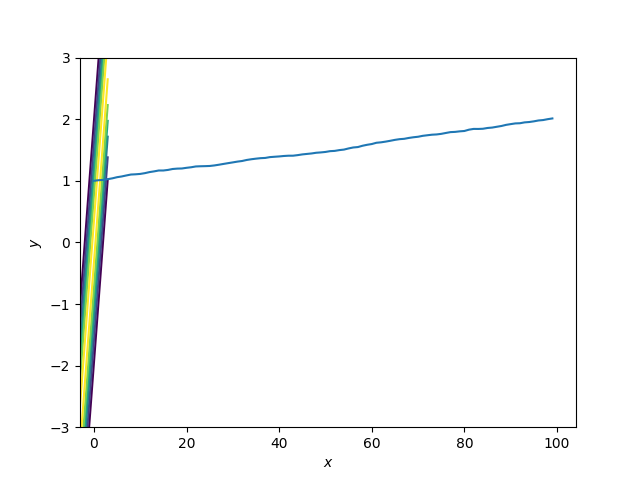

In [3]:
beam = GaussianBeam(1.0, np.array([1.0,1.0,0.0]),np.array([1.0, 1.0, 0.0]), 1.0)

num_pts = 10
x_min = -3
x_max = 3
y_min = -3
y_max = 3

x = np.linspace(x_min, x_max, num_pts)
y = np.linspace(x_min, x_max, num_pts)
pts = np.array([[x[i], y[j], 0] for i in range(num_pts) for j in range(num_pts)])
intensities = beam.intensities(pts).reshape(num_pts, num_pts)
xx, yy = np.meshgrid(x, y)
plt.contour(xx, yy, intensities)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

Besides the intensity we also need to tell RadiationPressure what the laser-atom detuning is. Here we assume that we only need to account for Doppler shifts and thus we have

$$
\Delta(\mathbf{x}, \mathbf{v}) = \Delta_0-\mathbf{k}\cdot\mathbf{v}.
$$

The frequency $\Delta_0$ is the detuning between laser and atomic transition when the atom is at rest. Here is a class to represent this detuning:

In [21]:
class DopplerDetuning(object):
    def __init__(self, Delta0, k):
        self.Delta0 = Delta0
        self.k = np.copy(k)
        
    def detunings(self, x, v):
        return self.Delta0 + np.inner(self.k, v)

In [22]:
detuning = DopplerDetuning(-0.5, (1, 0, 0))

As a first example we consider a single atom being laser cooled along the $x$ dimension. The particle starts out with a velocity of $1\rm{m}/\rm{s}$.

In [71]:
ensemble = coldatoms.Ensemble(num_ptcls=1)
ensemble.v[0, 0] = 5.0e0
ensemble.ensemble_properties['mass'] = 87*1.0e-27

In [72]:
ensemble.v

array([[ 5.,  0.,  0.]])

In [73]:
wavelength = 1.0e-6
k = 2.0 * np.pi / wavelength
gamma = 1.0e8
hbar = 1.0e-34
one_d_mot = [
    coldatoms.RadiationPressure(gamma, np.array([hbar * k, 0.0, 0.0]),
                      GaussianBeam(S0=0.1, x0=np.array([0.0, 0.0, 0.0]), k=np.array([k, 0.0, 0.0]), sigma=1.0e-4),
                      DopplerDetuning(0.5 * gamma, np.array([k, 0.0, 0.0]))),
    coldatoms.RadiationPressure(gamma, np.array([-hbar * k, 0.0, 0.0]),
                      GaussianBeam(S0=0.1, x0=np.array([0.0, 0.0, 0.0]), k=np.array([-k, 0.0, 0.0]), sigma=1.0e-4),
                      DopplerDetuning(0.5 * gamma, np.array([-k, 0.0, 0.0])))]

In [74]:
x = []
vx = []
for i in range(2000):
    x.append(ensemble.x[0, 0])
    vx.append(ensemble.v[0, 0])
    coldatoms.drift_kick(dt=1.0e-5, ensemble=ensemble, forces=one_d_mot)

<IPython.core.display.Javascript object>


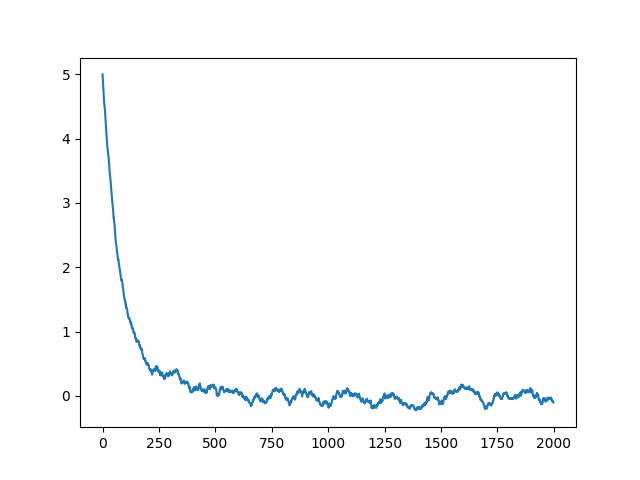

In [79]:
plt.figure()
plt.plot(vx)

<IPython.core.display.Javascript object>


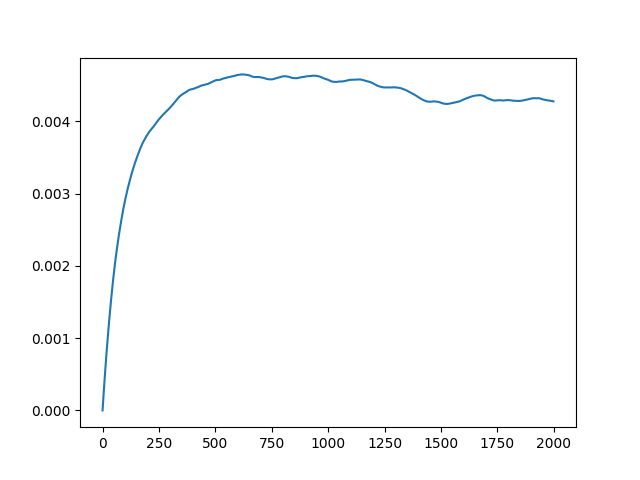

In [78]:
plt.figure()
plt.plot(x)